Urban GeoAI Starter Notebook
NDVI + LST Extraction (Sentinel-2 & Landsat 8) for Dublin
Google Drive + Optional GitHub push

In [2]:
!pip install -q geemap earthengine-api geopandas rasterio numpy pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.1 MB/s eta 0:00:00


In [3]:
import ee
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
project_path = '/content/drive/MyDrive/urban-geoai'
notebooks_path = os.path.join(project_path, 'notebooks')
data_raw_path = os.path.join(project_path, 'data/raw')
data_processed_path = os.path.join(project_path, 'data/processed')
outputs_maps_path = os.path.join(project_path, 'outputs/maps')
outputs_figures_path = os.path.join(project_path, 'outputs/figures')

Authenticate & initialize Google Earth Engine

In [6]:
ee.Authenticate()

In [7]:
ee.Initialize(project="urban-geoai")

Define study area - Dublin

In [8]:
urban_bbox = ee.Geometry.Rectangle([-6.28, 53.33, -6.23, 53.37])  # West, South, East, North
Map = geemap.Map(center=[53.35, -6.255], zoom=12)
Map.addLayer(urban_bbox, {}, 'Dublin Urban Area')
Map

Map(center=[53.35, -6.255], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Sentinel-2 NDVI

In [9]:
sentinel = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(urban_bbox) \
    .filterDate('2023-06-01', '2023-08-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

sentinel_median = sentinel.median()
ndvi = sentinel_median.normalizedDifference(['B8', 'B4']).rename('NDVI')
Map.addLayer(ndvi, {'min':0, 'max':1, 'palette':['white','green']}, 'NDVI')

NDVI visualization

In [15]:
geemap.ee_tile_layer(ndvi, {'min':0,'max':1,'palette':['white','green']}, 'NDVI Layer')
Map

Map(bottom=340175.0, center=[53.35, -6.255], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

Landsat 8 LST

In [10]:
landsat = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterBounds(urban_bbox) \
    .filterDate('2023-06-01', '2023-08-31')

landsat_median = landsat.median()

# Correct LST band and scaling
lst = landsat_median.select('ST_B10') \
    .multiply(0.00341802) \
    .add(149.0) \
    .subtract(273.15) \
    .rename('LST')

Map.addLayer(
    lst,
    {'min': 10, 'max': 35, 'palette': ['blue', 'cyan', 'yellow', 'orange', 'red']},
    'LST (°C)'
)

Quick LST visualisation

In [11]:
geemap.ee_tile_layer(lst, {'min':20,'max':40,'palette':['blue','yellow','red']}, 'LST Layer')
Map

Map(center=[53.35, -6.255], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Export NDVI & LST to Drive

In [16]:
ndvi_task = ee.batch.Export.image.toDrive(
    image=ndvi.clip(urban_bbox),
    description='NDVI_export_Dublin',
    folder='urban-geoai',
    scale=10,
    region=urban_bbox.getInfo()['coordinates'],
    fileFormat='GeoTIFF'
)
lst_task = ee.batch.Export.image.toDrive(
    image=lst.clip(urban_bbox),
    description='LST_export_Dublin',
    folder='urban-geoai',
    scale=30,
    region=urban_bbox.getInfo()['coordinates'],
    fileFormat='GeoTIFF'
)

ndvi_task.start()
lst_task.start()
print("NDVI and LST export to drive.")

NDVI and LST export to drive.


Compute simple stats and save CSV

In [12]:
ndvi_stats = ndvi.reduceRegion(reducer=ee.Reducer.mean(), geometry=urban_bbox, scale=10)
lst_stats = lst.reduceRegion(reducer=ee.Reducer.mean(), geometry=urban_bbox, scale=30)

stats_df = pd.DataFrame({
    'Metric': ['NDVI','LST'],
    'Mean': [ndvi_stats.get('NDVI').getInfo(), lst_stats.get('LST').getInfo()]
})
csv_path = os.path.join(data_processed_path, 'ndvi_lst_stats_dublin.csv')
stats_df.to_csv(csv_path, index=False)
print(f"Stats saved to {csv_path}")

Stats saved to /content/drive/MyDrive/urban-geoai/data/processed/ndvi_lst_stats_dublin.csv


Quick plot of stats

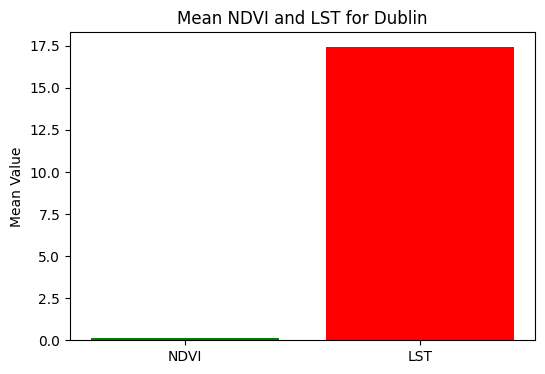

In [13]:
plt.figure(figsize=(6,4))
plt.bar(stats_df['Metric'], stats_df['Mean'], color=['green','red'])
plt.ylabel('Mean Value')
plt.title('Mean NDVI and LST for Dublin')
plt.show()

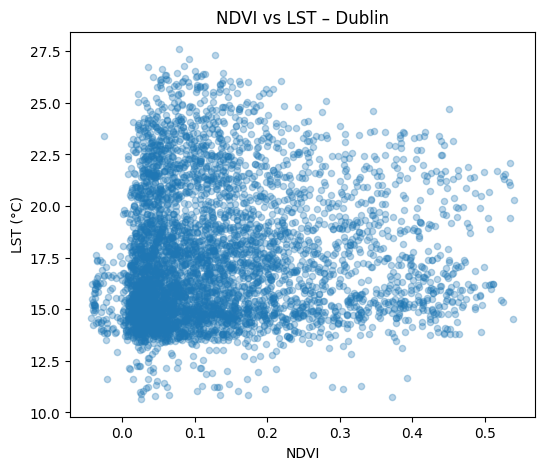

In [14]:
sample = ndvi.addBands(lst).sample(
    region=urban_bbox,
    scale=30,
    numPixels=5000,
    geometries=False
)

df = geemap.ee_to_df(sample)

df.plot.scatter(x='NDVI', y='LST', alpha=0.3, figsize=(6,5))
plt.title('NDVI vs LST – Dublin')
plt.xlabel('NDVI')
plt.ylabel('LST (°C)')
plt.show()

NDBI Visualisation

In [17]:
ndbi = landsat_median.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')

ndbi_vis = {
    'min': -0.5,
    'max': 0.5,
    'palette': ['green', 'white', 'brown']
}

Map.addLayer(ndbi, ndbi_vis, 'NDBI (Built-up)')
Map


Map(bottom=42758.0, center=[53.39315656538044, -5.833740234375001], controls=(WidgetControl(options=['position…

Analyse NDBI vs LST

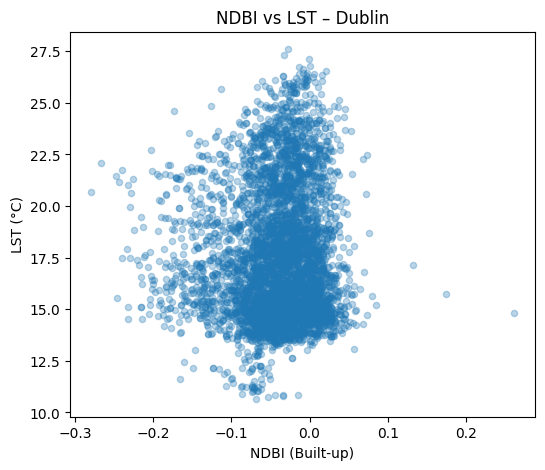

In [18]:
sample = ndbi.addBands(lst).sample(
    region=urban_bbox,
    scale=30,
    numPixels=5000
)

df_ndbi = geemap.ee_to_df(sample)

df_ndbi.plot.scatter(
    x='NDBI',
    y='LST',
    alpha=0.3,
    figsize=(6,5)
)

plt.title('NDBI vs LST – Dublin')
plt.xlabel('NDBI (Built-up)')
plt.ylabel('LST (°C)')
plt.show()
